In [1]:
!pip install pytorch_msssim

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import pytorch_msssim.ssim as cal_ssim
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Oct 31 13:56:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    46W / 350W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, 
                      padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1,
                      bias=False)
        )

    def forward(self, x):
        return x + self.block(x)

class VQVAE(nn.Module):
    def __init__(self, img_channels, latent_size, latent_dim):
        super(VQVAE, self).__init__()
        
        self.K = latent_size
        self.D = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, self.D, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.D, self.D, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ResidualBlock(self.D, self.D), 
            nn.ReLU(),
            ResidualBlock(self.D, self.D), 
            nn.ReLU(),
        )
        
        self.codebook = nn.Embedding(self.K, self.D)
        self.codebook.weight.data.uniform_(-1/self.K, 1/self.K)
        
        self.decoder = nn.Sequential(
            ResidualBlock(self.D, self.D), 
            nn.ReLU(),
            ResidualBlock(self.D, self.D), 
            nn.ReLU(),
            nn.ConvTranspose2d(self.D, self.D, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(self.D, img_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )

        
    def vector_quantize(self, z_e):
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_e_shape = z_e.shape

        flat_z_e = z_e.view(-1, self.D)
        
        # distances = torch.pow(
        #     torch.sum(flat_z_e, dim=1, keepdim=True) - 
        #     torch.sum(self.codebook.weight, dim=1), 2)
        
        distances = (torch.sum(flat_z_e**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(flat_z_e, self.codebook.weight.t()))
        
        q = torch.argmin(distances, dim=1, keepdim=True).view(z_e_shape[:-1])
        # q = torch.argmin(distances, dim=1, keepdim=True)

        # print(torch.argmin(distances, dim=-1, keepdim=True).view(z_e_shape[:-1]).shape)

        # q = torch.argmin(distances, dim=1).unsqueeze(1)
        # q_ont_hot = torch.zeros(distances.shape).to(device)
        # q_ont_hot.scatter_(1, q, 1)
        # z_q = torch.matmul(q_ont_hot, self.codebook.weight).view(z_e_shape)

        z_q = self.codebook(q)

        codebook_loss = F.mse_loss(z_q.detach(), z_e)
        commit_loss = F.mse_loss(z_q, z_e.detach())
        vq_loss = codebook_loss + commit_loss

        z_q = z_e + (z_q - z_e).detach()
        
        return q, vq_loss, z_q.permute(0, 3, 1, 2).contiguous()
    
    def forward(self, imgs):
        z_e = self.encoder(imgs)
        _, vq_loss, encoded = self.vector_quantize(z_e)
        decoded = self.decoder(encoded)
        
        return encoded, decoded, vq_loss

In [6]:
# def cal_ssim(img1, img2):
#     img1 = np.transpose(img_as_float(img1.numpy()), (1,2,0))
#     img2 = np.transpose(img_as_float(img2.numpy()), (1,2,0))
#     return ssim(img1, img2, multichannel=True)
    
def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')

In [7]:
def train(model, optim, epoch_size, train_loader, valid_loader):
    train_status = {'total_loss': [], 'reconst_loss': [], 
                    'vq_loss': [], 'train_ssim': [], 'valid_ssim': []}
    
    for epoch in range(epoch_size):
        model.train()
        total = 0
        reconst = 0
        vq = 0
        train_ssim = 0
        
        train_loop = tqdm(enumerate(train_loader), total=len(train_loader))
        train_loop.set_description(f"Epoch [{epoch+1}/{epoch_size}]")
        
        for batch, imgs in train_loop:
            imgs = imgs.to(device)
            encoded, decoded, vq_loss = model(imgs)

            
            # reconst_loss = F.mse_loss(decoded, imgs, reduction='none')
            # reconst_loss = reconst_loss.reshape(imgs.shape[0], -1).sum(axis=1).mean()

            reconst_loss = F.mse_loss(decoded, imgs)

            # vq_loss = F.mse_loss(encoded, z_e.detach())
            # commit_loss = F.mse_loss(encoded.detach(), z_e)
            # loss = reconst_loss + vq_loss + 0.25 * commit_loss

            loss = reconst_loss + vq_loss
          
            optim.zero_grad()
            loss.backward()
            optim.step() 

            total += loss.item()
            reconst += reconst_loss.item()
            vq += vq_loss.item()
            train_ssim += cal_ssim(make_grid(imgs.detach().data).unsqueeze(0), 
                                   make_grid(decoded.detach().data).unsqueeze(0), 
                                   data_range=1, size_average=False).item()
            
            train_loop.set_postfix(reconst_loss=reconst/(batch+1),
                                   train_ssim=train_ssim/(batch+1))

        
            
            if batch == len(train_loader)-1:
                train_status['total_loss'].append(total/(batch+1))
                train_status['reconst_loss'].append(reconst/(batch+1))
                train_status['vq_loss'].append(vq/(batch+1))
                train_status['train_ssim'].append(train_ssim/(batch+1))
                
                model.eval()
                
                ssim = 0
                for batch, imgs in enumerate(valid_loader):
                    imgs = imgs.to(device)
                    _, decoded, _ = model(imgs)
                    imgs = make_grid(imgs.detach().data).unsqueeze(0)
                    decoded = make_grid(decoded.detach().data).unsqueeze(0)
                    ssim += cal_ssim(imgs, decoded, data_range=1, 
                                        size_average=False).item()

                train_status['valid_ssim'].append(ssim/(batch + 1))
                train_loop.set_postfix(
                    reconst_loss=train_status['reconst_loss'][-1],
                    train_ssim=train_status['train_ssim'][-1],
                    valid_ssim=train_status['valid_ssim'][-1]
                    )
        
    return train_status

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

train_data = torch.load('/content/gdrive/MyDrive/data/mri_brain_train.pt')
valid_data = torch.load('/content/gdrive/MyDrive/data/mri_brain_validate.pt') 
test_data = torch.load('/content/gdrive/MyDrive/data/mri_brain_test.pt') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
EPOCH_SIZE = 20
BATCH_SIZE = 32
# LR = 0.01
LR = 0.002
# LR = 0.00005
K = 512
D = 64

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, 
                                           shuffle=True, num_workers=0)

valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, 
                                           shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=4, 
                                          shuffle=True, num_workers=0)

In [10]:
# del vqvae
# torch.cuda.empty_cache()

In [11]:
vqvae = VQVAE(1, K, D).to(device)
# optim = torch.optim.SGD(params=vqvae.parameters(), lr=LR, momentum=0.9)
optim = torch.optim.Adam(params=vqvae.parameters(), lr=LR)
train_status = train(vqvae, optim, EPOCH_SIZE, train_loader, valid_loader)

Epoch [20/20]: 100%|██████████| 302/302 [00:10<00:00, 27.83it/s, reconst_loss=0.000624, train_ssim=0.929, valid_ssim=0.929]


In [27]:
# checkpoint = {
#     'K': K,
#     'D': D,
#     'train_status': train_status,
#     'state_dict': vqvae.state_dict()
# }

# torch.save(checkpoint, '/content/gdrive/MyDrive/model/vqvae_trained.pt')

In [13]:
vqvae.eval()

img = next(iter(test_loader))
img = img.to(device)
encoded, decoded, _ = vqvae(img)

In [14]:
print(img.shape)
print(decoded.shape)
print(F.mse_loss(img, decoded, reduction='none').reshape(64, -1).sum(1).mean())

torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])
tensor(3.0107, device='cuda:0', grad_fn=<MeanBackward0>)


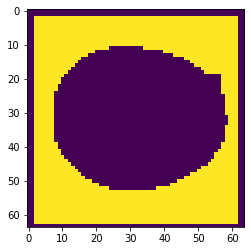

In [15]:
plt.imshow(encoded.cpu().detach().numpy()[0][0])

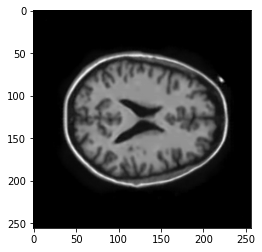

In [16]:
# plt.imshow(decoded.cpu().detach().numpy()[0].transpose((1,2,0)), interpolation='nearest')
plt.imshow(decoded.cpu().detach().numpy()[0][0], cmap='gray')

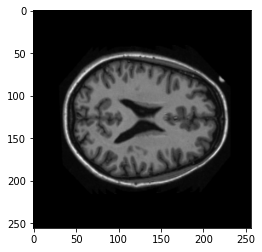

In [17]:
# plt.imshow(img.cpu().detach().numpy()[0].transpose((1,2,0)), interpolation='nearest')
plt.imshow(img.cpu().detach().numpy()[0][0], cmap='gray')

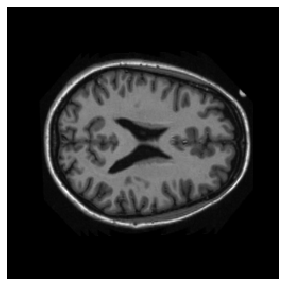

In [18]:
show(make_grid(img.cpu().data[0], nrow=16, padding=0))

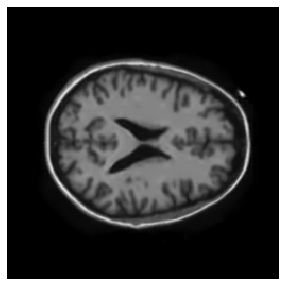

In [19]:
show(make_grid(decoded.cpu().data[0], nrow=16, padding=0))

In [20]:
print(cal_ssim(make_grid(img.data).unsqueeze(0), make_grid(decoded.data).unsqueeze(0)).item())

0.9999463558197021


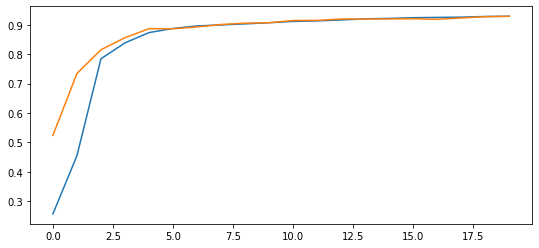

In [26]:
plt.figure(figsize=(9, 4))
plt.plot(range(0, len(train_status['train_ssim'])), train_status['train_ssim'])
plt.plot(range(0, len(train_status['valid_ssim'])), train_status['valid_ssim'])
# plt.plot(range(0, len(train_status['total_loss'])), train_status['total_loss'])
# plt.plot(range(0, len(train_status['reconst_loss'])), train_status['reconst_loss'])
# plt.plot(range(0, len(train_status['vq_loss'])), train_status['vq_loss'])